<a href="https://colab.research.google.com/github/Viny2030/NLP/blob/main/PdfDataSource.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <br/>
    <img alt="Spark Pdf" src="https://stabrise.com/media/filer_public_thumbnails/filer_public/16/d6/16d6a0d6-f162-42ad-a5a3-7dc20361ad24/sparkpdf.png__1000x300_subsampling-2.webp" width="450" style="max-width: 100%;">
  <br/>
</p>

This notebook demonstrates how to use the PDF Datasource to load multiple page PDF files with Apache Spark.

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/spark-pdf/blob/main/examples/PdfDataSource.ipynb">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://search.maven.org/artifact/com.stabrise/spark-pdf-spark35_2.12">
        <img alt="Maven Central Version" src="https://img.shields.io/maven-central/v/com.stabrise/spark-pdf-spark35_2.12">
    </a>
    <a href="https://github.com/StabRise/spark-pdf/blob/master/LICENSE" >
        <img src="https://img.shields.io/badge/License-AGPL%203-blue.svg" alt="License"/>
    </a>
</p>

---

**Source Code**: [https://github.com/StabRise/spark-pdf](https://github.com/StabRise/spark-pdf)

⭐ Star us on GitHub — it motivates us a lot!

---

## Key features:

- Read PDF documents to the Spark DataFrame
- Support read PDF files lazy per page
- Support big files, up to 10k pages
- Support scanned PDF files (call OCR)
- No need to install Tesseract OCR, it's included in the package

In [ ]:
# Install PySpark and Pillow for display images
%pip install pyspark==3.5.0
%pip install Pillow

## Creating Spark Session with Spark Pdf DataSource

In [ ]:
import io
from PIL import Image
from IPython.display import display
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

builder = SparkSession.builder \
    .master("local[*]") \
    .config("spark.jars.packages", "com.stabrise:spark-pdf-spark35_2.12:0.1.11") \
    .config("spark.driver.memory", "8g") \
    .appName("SparkPdf")

spark = builder.getOrCreate()
spark

24/12/06 07:42:57 WARN Utils: Your hostname, nmelnik-1-0 resolves to a loopback address: 127.0.1.1; using 192.168.1.117 instead (on interface wlo1)
24/12/06 07:42:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/nmelnik/.ivy2/cache
The jars for the packages stored in: /home/nmelnik/.ivy2/jars
com.stabrise#spark-pdf-spark35_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6803202a-b5e1-4ed9-8974-9039c9113fa1;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/nmelnik/.cache/pypoetry/virtualenvs/pyspark-pdf-PXZQJpc2-py3.11/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.stabrise#spark-pdf-spark35_2.12;0.1.11 in central
	found com.stabrise#spark35_2.12;0.1.11 in central
	found com.stabrise#common_2.12;0.1.11 in central
	found org.apache.pdfbox#pdfbox;2.0.24 in central
	found org.apache.pdfbox#fontbox;2.0.24 in central
	found org.bytedeco#tesseract-platform;5.3.4-1.5.10 in central
	found org.bytedeco#leptonica-platform;1.84.1-1.5.10 in central
	found org.bytedeco#javacpp-platform;1.5.10 in central
	found org.bytedeco#javacpp;1.5.10 in central
	found org.bytedeco#leptonica;1.84.1-1.5.10 in central
	found org.bytedeco#tesseract;5.3.4-1.5.10 in central
	found net.sourceforge.tess4j#tess4j;5.11.0 in central
	found net.java.dev.jna#jna;5.14.0 in central
	found com.github.jai-imageio#jai-imageio-core;1.4.0 in central
	found org.apache.pdfbox#pdfbox-tools;3.0.1 in central
	found org.apache.pdfbox#pdfbox-debugger;3.0.1 in central
	found info.picocli#picocli;4.7.5 in central
	found org.apache.pdfbox#jbig2-imageio;3.0.4 in central
	found commons-io#com

## Loading pdf documents to the Spark

In [ ]:
# Downloading example PDF files
import urllib.request

filenames = ["./example1.pdf", "./example2.pdf", "./example3.pdf"]
url = f"https://raw.githubusercontent.com/StabRise/spark-pdf/refs/heads/main/examples/"
for f in filenames:
    urllib.request.urlretrieve(url + f.split("/")[-1], f)

In [ ]:
df = spark.read.format("pdf") \
    .option("imageType", "BINARY") \
    .option("resolution", "300") \
    .option("pagePerPartition", "8") \
    .option("reader", "pdfBox") \
    .load(filenames)

Available options for the data source:

- `imageType`: Oputput image type. Can be: "BINARY", "GREY", "RGB". Default: "RGB".
- `resolution`: Resolution for rendering PDF page to the image. Default: "300" dpi.
- `pagePerPartition`: Number pages per partition in Spark DataFrame. Default: "5".
- `reader`: Supports: `pdfBox` - based on PdfBox java lib, `gs` - based on GhostScript (need installation GhostScipt to the system)

### Counting total number of pages in all documents

Spark PDF operates with a lazy evaluation approach, extracting metadata from PDF files without loading the entire file into memory.

In this example, we loaded two PDF documents:  
- The first document contains 1 page.  
- The second document contains 1 page with not recognized text.
- The last one document contains 30 pages.


In [ ]:
df.count()

32

### Checking Number of Partitions

We specified the option `pagePerPartition = 8` in the configuration.<br/>
This results in 6 partitions:  
- 1 partition for the first file.  
- 1 partition for the second file.  
- 4 partitions for the last file, which contains 30 pages.  

In [ ]:
df.rdd.getNumPartitions()

6

### Showing the DataFrame

The DataFrame contains the following columns:

- `path`: path to the file
- `page_number`: page number of the document
- `text`: extracted text from the text layer of the PDF page
- `image`: image representation of the page
- `document`: the OCR-extracted text from the rendered image (calls Tesseract OCR)
- `partition_number`: partition number

In [ ]:
df.select("filename", "page_number", "partition_number", "text") \
    .orderBy("filename", "page_number") \
    .show()

+------------+-----------+----------------+--------------------+
|    filename|page_number|partition_number|                text|
+------------+-----------+----------------+--------------------+
|example1.pdf|          0|               4|RECIPE\nStrawberr...|
|example2.pdf|          0|               5|                  \n|
|example3.pdf|          0|               0|Lorem ipsum \nLor...|
|example3.pdf|          1|               0|In non mauris jus...|
|example3.pdf|          2|               0|Lorem ipsum dolor...|
|example3.pdf|          3|               0|Maecenas mauris l...|
|example3.pdf|          4|               0|Etiam vehicula lu...|
|example3.pdf|          5|               0|Lorem ipsum \nLor...|
|example3.pdf|          6|               0|In non mauris jus...|
|example3.pdf|          7|               0|Lorem ipsum dolor...|
|example3.pdf|          8|               1|Maecenas mauris l...|
|example3.pdf|          9|               1|Etiam vehicula lu...|
|example3.pdf|         10

24/12/06 07:43:31 WARN PDType1Font: Using fallback font LiberationSans for base font Symbol
24/12/06 07:43:31 WARN PDType1Font: Using fallback font LiberationSans for base font ZapfDingbats


In [ ]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- page_number: integer (nullable = true)
 |-- partition_number: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- resolution: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |    |-- imageType: string (nullable = true)
 |    |-- exception: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |-- document: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- outputType: string (nullable = true)
 |    |-- bBoxes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |    |    |-- score: float (nullable = true)
 |    |    |    |-- x: integer (nullable = true)
 |    |    |    |-- y: intege

##  PDF document page with text layer (digital/searchable PDF).

In [ ]:
# Loading first page of some document
row = spark.read.format("pdf") \
    .option("imageType", "BINARY") \
    .option("resolution", "300") \
    .option("pagePerPartition", "8") \
    .option("reader", "pdfBox") \
    .load(["example1.pdf"]) \
    .select("page_number", "text", "image.data", "path") \
    .limit(1) \
    .collect()[0]

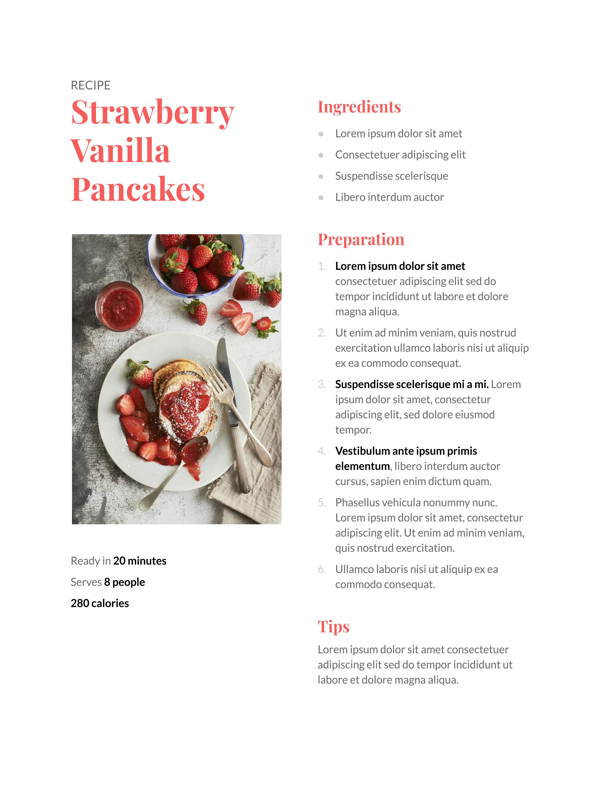

In [ ]:
# Image representation of the page
display(Image.open(io.BytesIO(row.data)).resize((600, 800)))

In [ ]:
print(row.text) # Text representation of the page.

RECIPE
Strawberry
Vanilla
Pancakes
Ready in 20minutes
Serves 8 people
280 calories
Ingredients
● Lorem ipsum dolor sit amet
● Consectetuer adipiscing elit
● Suspendisse scelerisque
● Libero interdum auctor
Preparation
1. Lorem ipsum dolor sit amet
consectetuer adipiscing elit sed do
tempor incididunt ut labore et dolore
magna aliqua.
2. Ut enim adminim veniam, quis nostrud
exercitation ullamco laboris nisi ut aliquip
ex ea commodo consequat.
3. Suspendisse scelerisquemi ami. Lorem
ipsum dolor sit amet, consectetur
adipiscing elit, sed dolore eiusmod
tempor.
4. Vestibulum ante ipsum primis
elementum, libero interdum auctor
cursus, sapien enim dictum quam.
5. Phasellus vehicula nonummy nunc.
Lorem ipsum dolor sit amet, consectetur
adipiscing elit. Ut enim adminim veniam,
quis nostrud exercitation.
6. Ullamco laboris nisi ut aliquip ex ea
commodo consequat.
Tips
Lorem ipsum dolor sit amet consectetuer
adipiscing elit sed do tempor incididunt ut
labore et doloremagna aliqua.



## PDF document page containing image data (scanned or image based PDF)

In [ ]:
# Loading first page of the document with not recognized text data
row = spark.read.format("pdf") \
    .option("imageType", "BINARY") \
    .option("resolution", "300") \
    .option("pagePerPartition", "8") \
    .option("reader", "pdfBox") \
    .load(["example2.pdf"]) \
    .select("page_number", "text", "document", "image.data", "path") \
    .limit(1) \
    .collect()[0]

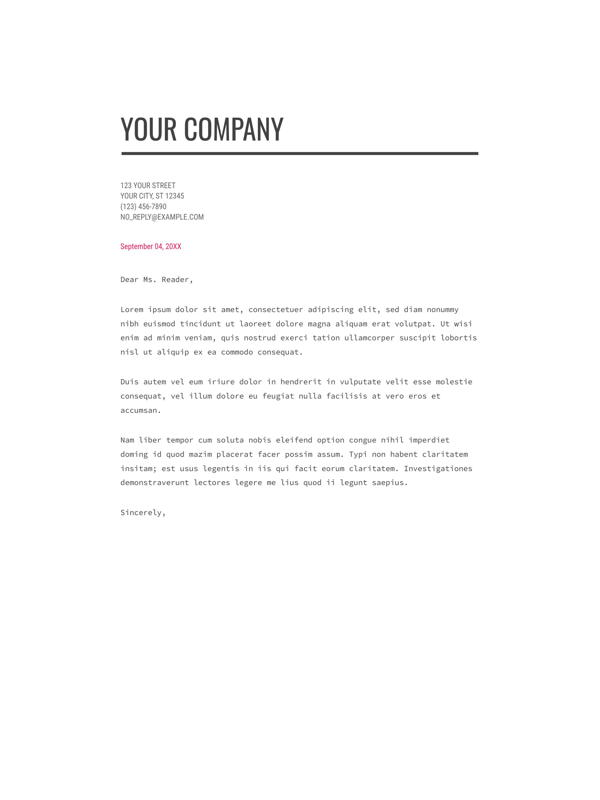

In [ ]:
display(Image.open(io.BytesIO(row.data)).resize((600, 800)))

In [ ]:
print(row.text) # it's empty, because this page doesn't contains text layer

In [ ]:
# Showing text recognized by the OCR
print(row.document.text)

ee
123 YOUR STREET

YOUR CITY, ST 12345

(123) 456-7890

NO_REPLY@EXAMPLE.COM

September 04, 20XX

Dear Ms. Reader,

Lorem ipsum dolor sit amet, consectetuer adipiscing elit, sed diam nonummy
nibh euismod tincidunt ut laoreet dolore magna aliquam erat volutpat. Ut wisi
enim ad minim veniam, quis nostrud exerci tation ullamcorper suscipit lobortis
nisl ut aliquip ex ea commodo consequat.

Duis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie
consequat, vel illum dolore eu feugiat nulla facilisis at vero eros et
accumsan.

Nam liber tempor cum soluta nobis eleifend option congue nihil imperdiet
doming id quod mazim placerat facer possim assum. Typi non habent claritatem
insitam; est usus legentis in iis qui facit eorum claritatem. Investigationes
demonstraverunt lectores legere me lius quod ii legunt saepius.

Sincerely,

